In [1]:
import sys; sys.path.append('..')

import torch
import torch.nn as nn
import torch.autograd.profiler as profiler

from dinr.modeling.modules.inr_generator import INRGenerator
from dinr.modeling.modules.noise import mixing_noise

device = 'cuda'
batch_size = 4
img_size = 256

In [26]:
num_runs = 10
common_kwargs = dict(
    size=img_size,
    style_dim=512,
    n_mlp=8,
    channel_multiplier=2,
    blur_kernel=(1, 3, 3, 1),
    lr_mlp=0.01,
    interpolation_type='nearest')

# gen = INRGenerator(fallback=True, transform_type='conv', is_multiscale=False, **common_kwargs).to(device)
with profiler.profile(record_shapes=True, use_cuda=True) as prof:
    for _ in range(num_runs):
        gen = INRGenerator(fallback=False, transform_type='conv', is_multiscale=False, **common_kwargs).to(device)
        with profiler.record_function("cips"):
            z = mixing_noise(batch_size, 512, 0.0, device)
            fake_img, latent = gen(z, return_latents=False)
            fake_img = fake_img.contiguous()
        del gen
        
        gen = INRGenerator(fallback=True, transform_type='conv', is_multiscale=False, **common_kwargs).to(device)
        with profiler.record_function("stylegan2"):
            z = mixing_noise(batch_size, 512, 0.0, device)
            fake_img, latent = gen(z, return_latents=False)
            fake_img = fake_img.contiguous()
        del gen

        gen = INRGenerator(fallback=False, transform_type='conv', is_multiscale=True, **common_kwargs).to(device)
        with profiler.record_function("ms_conv"):
            z = mixing_noise(batch_size, 512, 0.0, device)
            fake_img, latent = gen(z, return_latents=False)
            fake_img = fake_img.contiguous()
            
        del gen
        gen = INRGenerator(fallback=False, transform_type='fmm', is_multiscale=True, **common_kwargs).to(device)

        with profiler.record_function("ms_fmm"):
            z = mixing_noise(batch_size, 512, 0.0, device)
            fake_img, latent = gen(z, return_latents=False)
            fake_img = fake_img.contiguous()
            
#         with profiler.record_function("mapping_network"):
#             z = mixing_noise(batch_size, 512, 0.0, device)
#             styles = gen.style(z[0]).contiguous()
            #fake_img, latent = gen(z, return_latents=False)
            #fake_img = fake_img.contiguous()

In [56]:
from time import time

start = time()

with profiler.profile(record_shapes=True, use_cuda=True) as prof:
    with profiler.record_function("tmp"):
        for _ in range(50):
            a = nn.Linear(512, 512).to(device)
            x = torch.randn(64, 512).to(device)
            y = a(x)
        
elapsed = time() - start

In [4]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [39]:
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler

# in_dim = 256
# out_dim = 256
# batch_size = 16
# img_size = 128
device = 'cuda'
# device = 'cpu'
# x = torch.randn(batch_size, in_dim, img_size, img_size).to(device)
# conv3 = nn.Conv2d(in_dim, out_dim, 3).to(device)
# conv1 = nn.Conv2d(in_dim, out_dim, 1).to(device)
# w = torch.randn(out_dim, in_dim).to(device)
nn.Linear(512, 512).to(device)(torch.randn(16, 512).to(device)) # To init CUDA
nn.Conv2d(512, 512, 3).to(device)(torch.randn(16, 512, 8, 8).to(device)) # To init CUDA

num_runs = 10
blocks = [
    {'in_dim': 512, 'out_dim': 512, 'img_size': 8},
    {'in_dim': 512, 'out_dim': 512, 'img_size': 16},
    {'in_dim': 512, 'out_dim': 512, 'img_size': 32},
    {'in_dim': 512, 'out_dim': 512, 'img_size': 64},
    {'in_dim': 512, 'out_dim': 256, 'img_size': 128},
    {'in_dim': 256, 'out_dim': 256, 'img_size': 128},
    {'in_dim': 256, 'out_dim': 128, 'img_size': 256},
    {'in_dim': 128, 'out_dim': 64, 'img_size': 512},
    {'in_dim': 64, 'out_dim': 32, 'img_size': 1024},
]
# batch_sizes = [1, 2, 4, 8, 16]
batch_sizes = [1, 2]
# ops = ['conv1', 'conv3', 'hyper_linear', 'linear', 'linear_no_permute', 'hyper_conv1']
ops = ['conv1', 'conv3']
results = {}
# batch_sizes = [8]

def get_prop(name, prop, prof, avg: bool=False) -> float:
    val = getattr([k for k in prof.key_averages() if k.key == name][0], prop)
    
    if avg:
        val /= [k for k in prof.key_averages() if k.key == name][0].count
        
    return val

for block_idx, block in enumerate(blocks):
    results[block_idx] = {}
    in_dim, out_dim, img_size = block['in_dim'], block['out_dim'], block['img_size']
    
    #conv5 = nn.Conv2d(in_dim, out_dim, 5).to(device)
    conv3 = nn.Conv2d(in_dim, out_dim, 3, padding=1).to(device)
    conv1 = nn.Conv2d(in_dim, out_dim, 1).to(device)
    w = torch.randn(out_dim, in_dim).to(device)
    bias = torch.randn(out_dim).to(device)
    
    for batch_size in batch_sizes:
        results[block_idx][batch_size] = {}
        clockwall_time = {}
        x = torch.randn(batch_size, in_dim, img_size, img_size, device=device).contiguous()
        x_permuted = x.permute(0, 2, 3, 1).contiguous()#.view(-1, in_dim)

        with profiler.profile(record_shapes=True, use_cuda=True) as prof:
            for _ in range(num_runs):
#                 start = time()
#                 with profiler.record_function("hyper_conv1"):
#                     w_curr = w.view(out_dim, in_dim, 1, 1).repeat(batch_size, 1, 1, 1) # [out_dim, batch_size * in_dim, 1, 1]
#                     x_curr = x.view(1, batch_size * in_dim, img_size, img_size) # [1, batch_size * in_dim, img_size, img_size]
#                     bias_curr = bias.repeat(batch_size)
#                     y = F.conv2d(x_curr, w_curr, bias=bias_curr, groups=batch_size) # [1, batch_size * out_dim, img_size, img_size]
#                     y = y.view(batch_size, out_dim, img_size, img_size)
#                 clockwall_time['hyper_conv1'] = time() - start
                
                y = conv1(x).contiguous() # Warmup
                torch.cuda.synchronize()
                start = time()
                with profiler.record_function("conv1"):
                    y = conv1(x).contiguous()
                torch.cuda.synchronize()
                clockwall_time['conv1'] = (time() - start) * 1000
                
                y = conv3(x).contiguous() # Warmup
                torch.cuda.synchronize()
                start = time()
                with profiler.record_function("conv3"):
                    y = conv3(x).contiguous()
                torch.cuda.synchronize()
                clockwall_time['conv3'] = (time() - start) * 1000
                
#                 y = conv5(x).contiguous() # Warmup
#                 torch.cuda.synchronize()
#                 start = time()
#                 with profiler.record_function("conv5"):
#                     y = conv5(x).contiguous()
#                 clockwall_time['conv5'] = time() - start
                
#                 start = time()
#                 with profiler.record_function("linear"):
#                     y = F.linear(x.permute(0, 2, 3, 1), w, bias=bias) # [batch_size, img_size, img_size, out_dim]
#                     y = y.permute(0, 3, 1, 2).contiguous() # [batch_size, img_size, img_size, out_dim]
#                 clockwall_time['linear'] = time() - start
                    
#                 start = time()
#                 with profiler.record_function("linear_no_permute"):
#                     y = F.linear(x_permuted.view(-1, in_dim), w, bias=bias).contiguous() # [batch_size, img_size, img_size, out_dim]
#                 clockwall_time['linear_no_permute'] = time() - start

#                 start = time()
#                 with profiler.record_function("hyper_linear"):
#                     w_curr = w.unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size, out_dim, in_dim]
#                     bias_curr = bias.view(1, -1, 1).repeat(batch_size, 1, 1) # [batch_size, out_dim, 1]
#                     x_curr = x.view(batch_size, in_dim, -1) # [batch_size, in_dim, img_size ** 2]
#                     y = w_curr @ x_curr + bias_curr # [batch_size, out_dim, img_size ** 2]
#                     y = y.view(batch_size, out_dim, img_size, img_size).contiguous()
#                 clockwall_time['hyper_linear'] = time() - start

        results[block_idx][batch_size]['cpu'] = {op: get_prop(op, 'cpu_time_total', prof, avg=True) for op in ops}
        results[block_idx][batch_size]['cuda'] = {op: get_prop(op, 'cuda_time_total', prof, avg=True) for op in ops}
        results[block_idx][batch_size]['clockwall_time'] = clockwall_time
        
# print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total"))

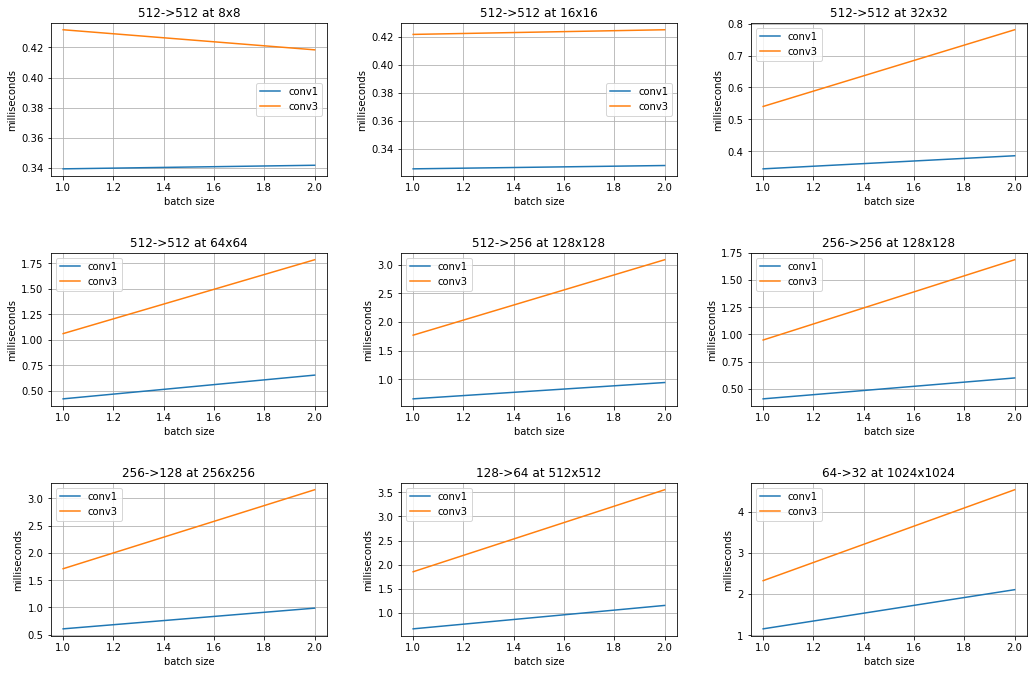

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ops_to_display = ops
# ops_to_display = ['hyper_linear', 'hyper_conv1']
ops_to_display = ['conv1', 'conv3']
ax1 = None

for block_idx in results:
    #ops_results = {op: [bs_results[op] for bs_results in results[block_idx]] for op in ops}
    #conv1_results = bs_results['conv1'] results[block_idx]
    if ax1 is None:
        ax1 = plt.subplot(3, (len(blocks) + 2) // 3, block_idx + 1)
    else:
        plt.subplot(3, (len(blocks) + 2) // 3, block_idx + 1)
    plt.title(f"{blocks[block_idx]['in_dim']}->{blocks[block_idx]['out_dim']} at {blocks[block_idx]['img_size']}x{blocks[block_idx]['img_size']}")
    plt.grid()

    for op in ops_to_display:
        #plt.plot(batch_sizes, [bs_results['cuda'][op] for bs_results in results[block_idx].values()], label=op)
        #plt.plot(batch_sizes, [bs_results['cpu'][op] for bs_results in results[block_idx].values()], label=op, lineStyle='--')
        plt.plot(batch_sizes, [bs_results['clockwall_time'][op] for bs_results in results[block_idx].values()], label=op)
        plt.legend()
        plt.ylabel('milliseconds')
        plt.xlabel('batch size')
        
plt.tight_layout(pad=3.0)

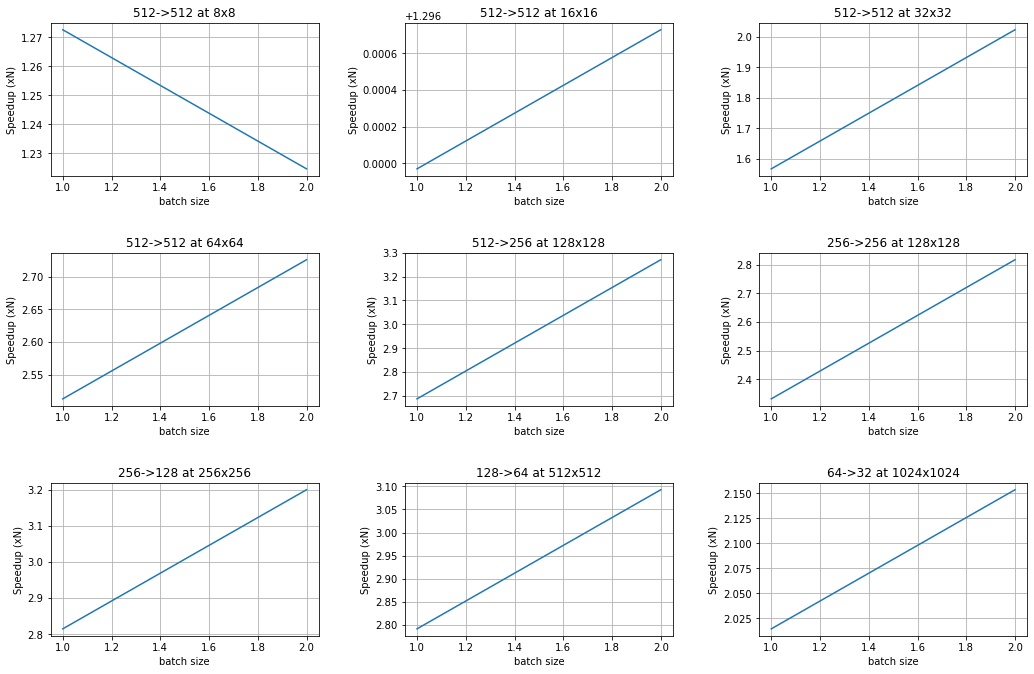

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ops_to_display = ops
# ops_to_display = ['hyper_linear', 'hyper_conv1']
ops_to_display = ['conv1', 'conv3']
ax1 = None

for block_idx in results:
    #ops_results = {op: [bs_results[op] for bs_results in results[block_idx]] for op in ops}
    #conv1_results = bs_results['conv1'] results[block_idx]
    if ax1 is None:
        ax1 = plt.subplot(3, (len(blocks) + 2) // 3, block_idx + 1)
    else:
        plt.subplot(3, (len(blocks) + 2) // 3, block_idx + 1)
    plt.title(f"{blocks[block_idx]['in_dim']}->{blocks[block_idx]['out_dim']} at {blocks[block_idx]['img_size']}x{blocks[block_idx]['img_size']}")
    plt.grid()
    
    conv1_times = [bs_results['clockwall_time']['conv1'] for bs_results in results[block_idx].values()]
    conv3_times = [bs_results['clockwall_time']['conv3'] for bs_results in results[block_idx].values()]
    speedup = [c3 / c1 for c1, c3 in zip(conv1_times, conv3_times)]

    #plt.plot(batch_sizes, [bs_results['cuda'][op] for bs_results in results[block_idx].values()], label=op)
    #plt.plot(batch_sizes, [bs_results['cpu'][op] for bs_results in results[block_idx].values()], label=op, lineStyle='--')
    plt.plot(batch_sizes, speedup)
    #plt.legend()
    plt.ylabel('Speedup (xN)')
    plt.xlabel('batch size')
        
plt.tight_layout(pad=3.0)